# https://youtu.be/Pql6ShORpNU
"""
Outlier detection using alibi-detect

Alibi Detect is an open source Python library focused on outlier, adversarial and drift detection. 
The package aims to cover both online and offline detectors for tabular data, text, 
images and time series. The outlier detection methods should allow the user to 
identify global, contextual and collective outliers.

pip install alibi-detect

https://github.com/SeldonIO/alibi-detect
Documentation: https://docs.seldon.io/_/downloads/alibi-detect/en/v0.5.1/pdf/

We will be using VAE based outlier detection. Based on this paper:
    https://arxiv.org/pdf/1312.6114.pdf
    
The Variational Auto-Encoder (VAE) outlier detector is first trained on a batch 
of unlabeled, but normal (inlier) data. Unsupervised training is desireable since 
labeled data is often scarce. The VAE detector tries to reconstruct the input it 
receives. If the input data cannot be reconstructed well, the reconstruction error 
is high and the data can be flagged as an outlier. The reconstruction error is either 
measured as the mean squared error (MSE) between the input and the reconstructed instance 
or as the probability that both the input and the reconstructed instance are 
generated by the same process.

Data set info: https://openaccess.thecvf.com/content_CVPR_2019/papers/Bergmann_MVTec_AD_--_A_Comprehensive_Real-World_Dataset_for_Unsupervised_Anomaly_CVPR_2019_paper.pdf
Data set link: https://www.mvtec.com/company/research/datasets/mvtec-ad
"""


In [3]:
%env TF_CPP_MIN_LOG_LEVEL=2

import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
# tf.keras.backend.set_floatx('float16')
print(tf.__version__)

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape, InputLayer, Flatten

from alibi_detect.models.tensorflow import elbo
from alibi_detect.od import OutlierAE, OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

env: TF_CPP_MIN_LOG_LEVEL=2
2.11.1


/home/skb/miniconda3/envs/tfcpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## force CPU

In [2]:
# print(tf.__version__)

# # Set CPU as available physical device
# my_devices = tf.config.experimental.list_physical_devices(device_type='CPU')
# tf.config.experimental.set_visible_devices(devices= my_devices, device_type='CPU')

# debug note
https://github.com/huggingface/transformers/issues/18549
pip uninstall tokenizers
pip install transformers

In [4]:
# !conda install -c conda-forge imgviz -y
# !pip install empatches

(271, 400, 3)
(201, 301, 3)
4
(200, 200, 3)


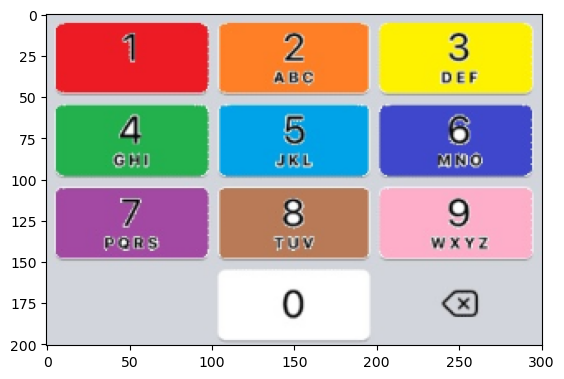

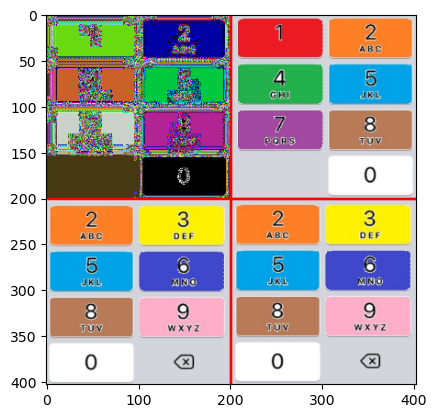

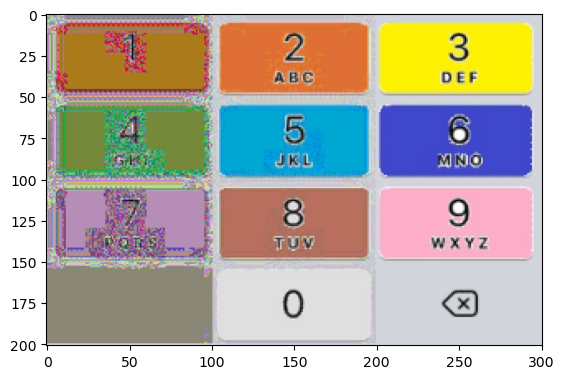

In [7]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from empatches import EMPatches
import imgviz # just for plotting


img = cv2.imread('numbs.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
height, width, channels = img.shape
# height = 525
# img = cv2.resize(img,(min(height, width,),min(height, width,)))

img = cv2.resize(img,(301,201))
print(img.shape)
plt.figure()
plt.imshow(img)
# load module
emp = EMPatches()
img_patches, indices = emp.extract_patches(img, patchsize=200, overlap=0.200)
print(len(img_patches))
print(np.rot90(img_patches[0]).shape)
# img_patches[-1] = np.rot90(img_patches[0])

img_patches[0] = img_patches[0]**2
# displaying 1st 10 image patches
tiled= imgviz.tile(list(map(np.uint8, img_patches[0:])),border=(255,0,0))
plt.figure()
plt.imshow(tiled)

merged_img = emp.merge_patches(img_patches, indices, mode='avg') # or
# display
plt.figure()
plt.imshow(merged_img.astype(np.uint8))

In [13]:
##########################################################################
#Load data. We only need good data and anything NOT good is an outlier. 
from natsort import natsorted

image_directory = './datasets/'
SIZE = 60
dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  

good_images = natsorted(os.listdir(image_directory + 'good/'))
for i, image_name in enumerate(good_images[:900]):
    # print (image_name)
    if (image_name.split('.')[-1] == 'jpg'):
        image = cv2.imread(image_directory + 'good/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
    

dataset = np.array(dataset)

train = dataset

train = train.astype('float32') / 255.

#Let us also load bad images to verify our trained model. 
bad_images = natsorted(os.listdir(image_directory + 'bad'))
bad_dataset=[]
for i, image_name in enumerate(bad_images):
    if (image_name.split('.')[-1] == 'jpg'):
        image = cv2.imread(image_directory + 'bad/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        bad_dataset.append(np.array(image))
bad_dataset = np.array(bad_dataset)
bad_dataset = bad_dataset.astype('float32') / 255.

#Let us also load mixed images to threshhold our model. 
mixed_images = natsorted(os.listdir(image_directory + 'mixed'))
mixed_dataset=[]
for i, image_name in enumerate(mixed_images):
    if (image_name.split('.')[-1] == 'jpg'):
        image = cv2.imread(image_directory + 'mixed/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        mixed_dataset.append(np.array(image))
mixed_dataset = np.array(mixed_dataset)
mixed_dataset = mixed_dataset.astype('float32') / 255.


train.shape

(799, 60, 60, 3)

In [4]:
print(bad_images[0])
print(bad_images[1])
print(bad_images[-1])

0000 (2).jpg
0000.jpg
PXL_20230509_131536970.jpg:Zone.Identifier


In [5]:
# #########################################################################
# #Define the encoder - decoder network for input to the OutlierVAE detector class. 
# #Can be any encoder and decoder. 
# # tf.keras.backend.clear_session()

# encoding_dim = 1024  #Dimension of the bottleneck encoder vector. 
# # dense_dim = [8, 8, 512] #Dimension of the last conv. output. This is used to work our way back in the decoder. 
# dense_dim = [16, 16, 512]
# #Define encoder
# encoder_net = tf.keras.Sequential(
#   [
#       InputLayer(input_shape=train[0].shape),                           # 128,128,3(input)
#       # filters, kernel_size, strides=(1, 1), padding=    
#       Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),  #>> 64*64*64
#       Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu), #>> 32*32*128
#       Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu), #>> 16*16*512
#       Flatten(),                                                          #>> 16x16x512=131072
#       Dense(encoding_dim,)                                                  #
#   ])

# print(encoder_net.summary())
# print("input shape: ",encoder_net.input_shape)

# #Define the decoder. 
# #Start with the bottleneck dimension (encoder vector) and connect to dense layer 
# #with dim = total nodes in the last conv. in the encoder. 
# decoder_net = tf.keras.Sequential(
#   [
#       InputLayer(input_shape=(encoding_dim,)),
#       Dense(np.prod(dense_dim)),
#       Reshape(target_shape=dense_dim),
#       Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
#       Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
#       Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
#   ])

# print(decoder_net.summary())
# print("output shape",decoder_net.input_shape)

# smaller network

In [14]:
#########################################################################
#Define the encoder - decoder network for input to the OutlierVAE detector class. 
#Can be any encoder and decoder. 

encoding_dim = 1024  #Dimension of the bottleneck encoder vector. 
dense_dim = [8, 8, 512] #Dimension of the last conv. output. This is used to work our way back in the decoder. 

#Define encoder
encoder_net_64 = tf.keras.Sequential(
  [
      InputLayer(input_shape=train[0].shape),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ])

print(encoder_net_64.summary())
#print(encoder_net.input_shape)

#Define the decoder. 
#Start with the bottleneck dimension (encoder vector) and connect to dense layer 
#with dim = total nodes in the last conv. in the encoder. 
decoder_net_64 = tf.keras.Sequential(
  [
      InputLayer(input_shape=(encoding_dim,)),
      Dense(np.prod(dense_dim)),
      Reshape(target_shape=dense_dim),
      Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ])

print(decoder_net_64.summary())
#print(decoder_net.input_shape)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 64)        3136      
                                                                 
 conv2d_4 (Conv2D)           (None, 15, 15, 128)       131200    
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 512)         1049088   
                                                                 
 flatten_801 (Flatten)       (None, 32768)             0         
                                                                 
 dense_4 (Dense)             (None, 1024)              33555456  
                                                                 
Total params: 34,738,880
Trainable params: 34,738,880
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_3"
_______________

In [15]:
#######################################################################
#Define and train the outlier detector. 

latent_dim = encoding_dim  #(Same as encoding dim. )

# initialize outlier detector
od = OutlierVAE(threshold=.015,  # threshold for outlier score above which the element is flagged as an outlier.
                score_type='mse',  # use MSE of reconstruction error for outlier detection
                encoder_net=encoder_net_64,  # can also pass VAE model instead
                decoder_net=decoder_net_64,  # of separate encoder and decoder
                latent_dim=latent_dim,
                samples=4)

print("Current threshold value is: ", od.threshold)


Current threshold value is:  0.015


In [16]:
# train
#from alibi_detect.models.tensorflow.losses import elbo #evidence lower bound loss

adam = tf.keras.optimizers.Adam(learning_rate=1e-4)


# # Run training on GPU
# with tf.device('/gpu:0'):
#     model.fit(...)

# Run train on CPU
# with tf.device('/cpu:0'):
    
    
history = od.fit(train,
                    loss_fn=elbo,
                    cov_elbo=dict(sim=.05),
                    optimizer = adam,
                    epochs=2,
                    batch_size=4,
                    verbose=True)

#Check the threshold value. Should be the same as defined before. 
print("Current threshold value is: ", od.threshold)

InvalidArgumentError: {{function_node __wrapped__Sub_device_/job:localhost/replica:0/task:0/device:GPU:0}} required broadcastable shapes [Op:Sub]

In [9]:
#
#infer_threshold Updates threshold by a value inferred from the percentage of 
#instances considered to be outliers in a sample of the dataset.
#percentage of X considered to be normal based on the outlier score.
#Here, we set it to 99%
# # Run inference on CPU
# with tf.device('/cpu:0'):
od.infer_threshold(mixed_dataset, outlier_type='instance', threshold_perc=72.0)
print("Current threshold value is: ", od.threshold)

Current threshold value is:  0.008006067983806134


In [10]:
# save the trained outlier detector
#As mentioned in their documentation, save and load is having issues in python3.6 but works fine in 3.7
# from alibi_detect.utils import save_detector, load_detector  #If this does not work, try the next line
# # from alibi_detect.utils.saving import save_detector, load_detector #Use this if the above line does not work. 
from alibi_detect.saving import save_detector
# filepath = './my_detector/'
# save_detector(od, filepath)

In [11]:
from alibi_detect.saving import load_detector

# filepath = './my_detector/'
# od = load_detector(filepath)

The instance score is: 0.006155686
Is this image an outlier (0 for NO and 1 for YES)? 0
['instance_score', 'feature_score', 'is_outlier']


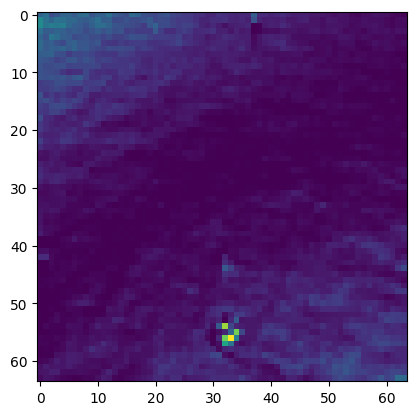

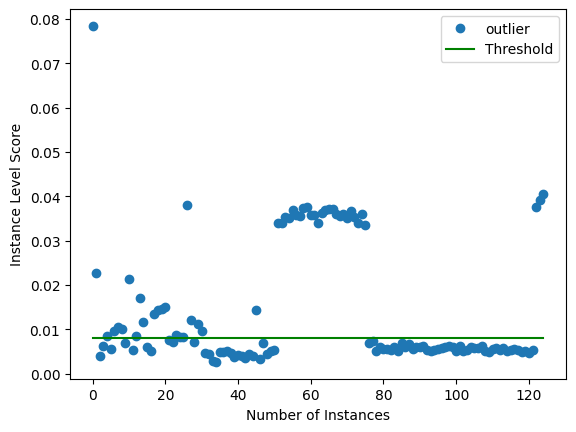

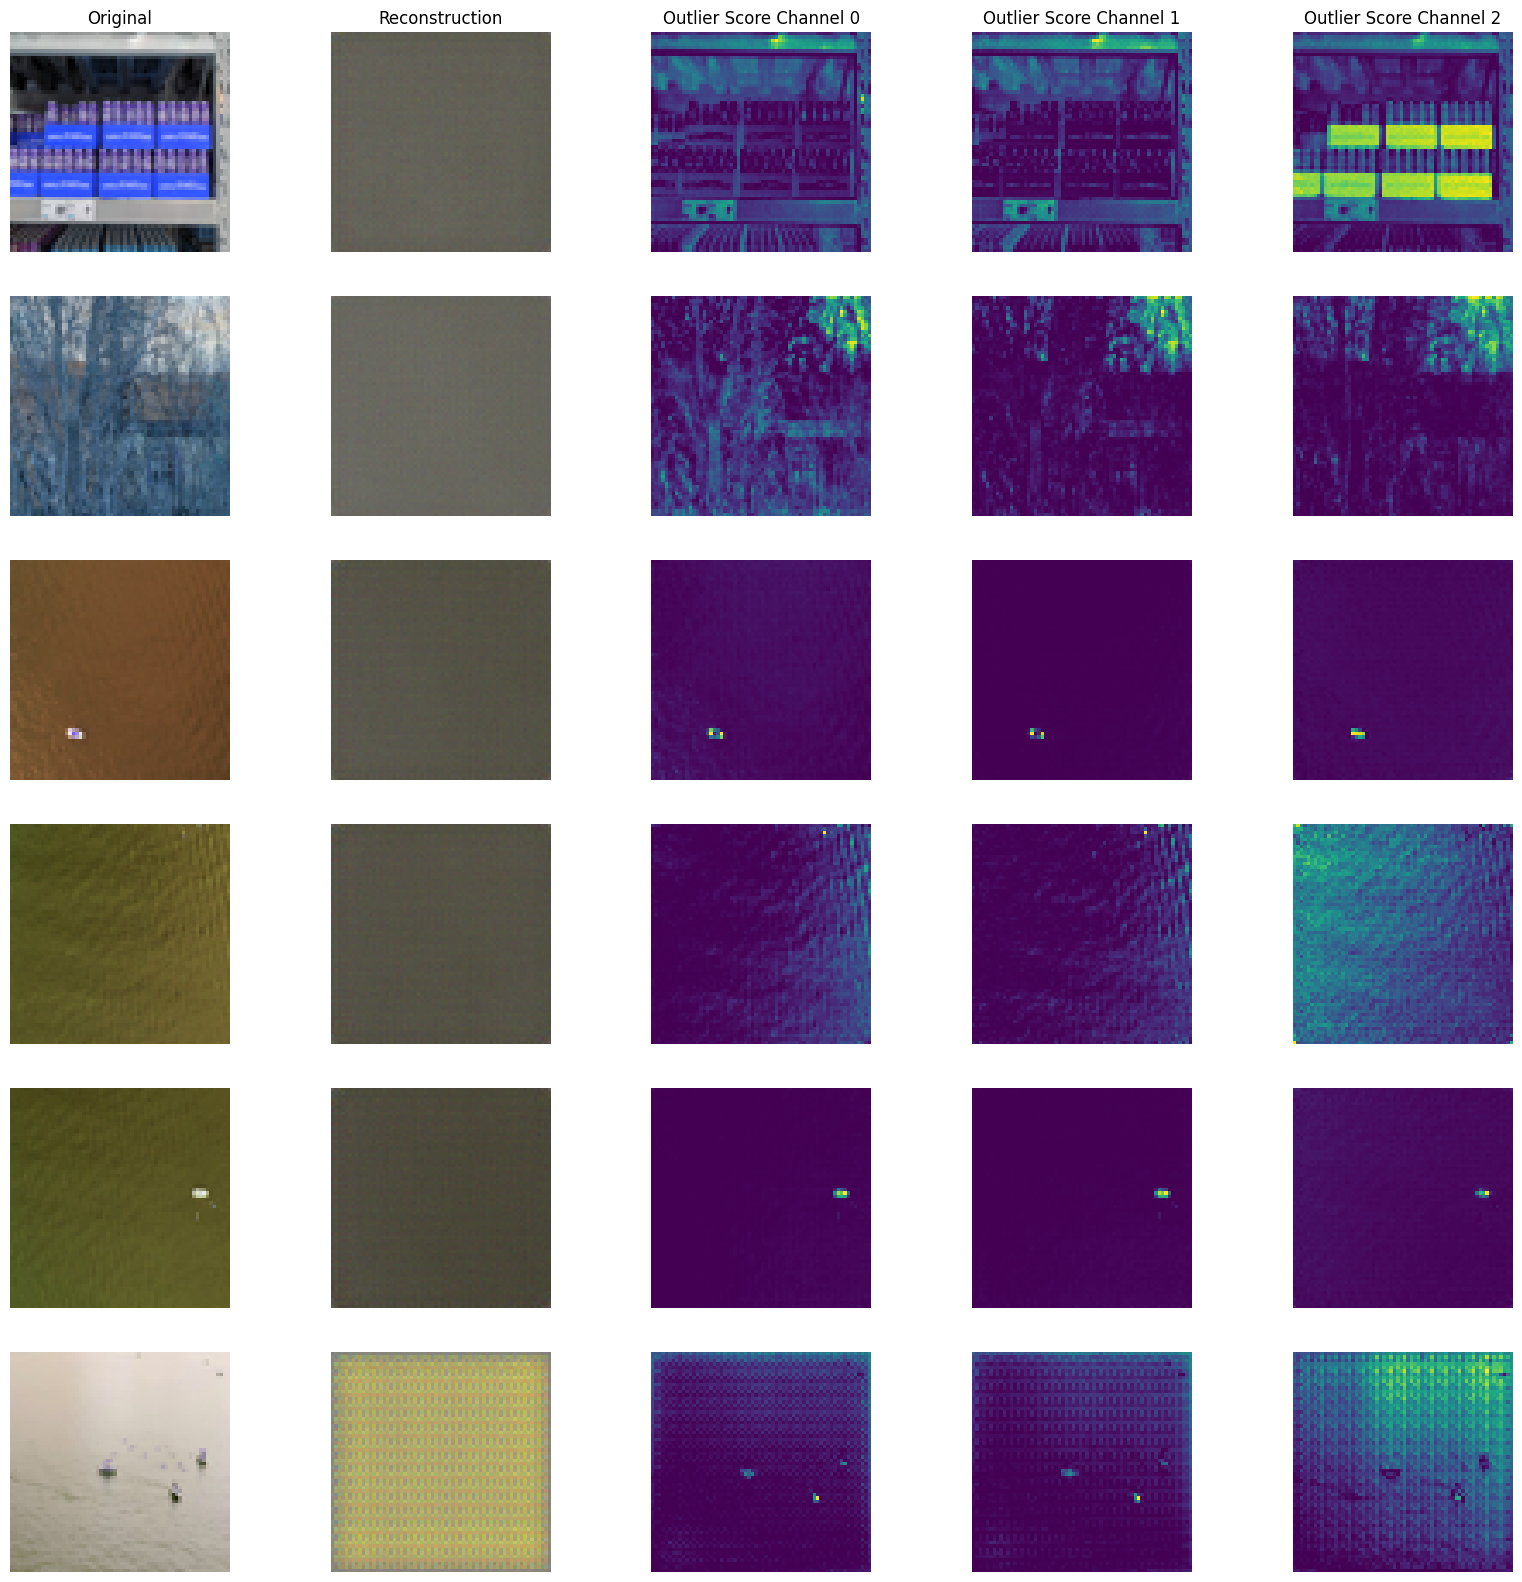

In [12]:
#Test our model on a bad image
img_num = 90
test_bad_image = bad_dataset[img_num].reshape(1, SIZE, SIZE, 3)
plt.imshow(test_bad_image[0])

test_bad_image_recon = od.vae(test_bad_image)
test_bad_image_recon = test_bad_image_recon.numpy()
plt.imshow(test_bad_image_recon[0])

test_bad_image_predict = od.predict(test_bad_image) #Returns a dictionary of data and metadata

#Data dictionary contains the instance_score, feature_score, and whether it is an outlier or not. 
#Let u look at the values under the 'data' key in our output dictionary
bad_image_instance_score = test_bad_image_predict['data']['instance_score'][0]
print("The instance score is:", bad_image_instance_score)

bad_image_feature_score = test_bad_image_predict['data']['feature_score'][0]
plt.imshow(bad_image_feature_score[:,:,0])
print("Is this image an outlier (0 for NO and 1 for YES)?", test_bad_image_predict['data']['is_outlier'][0])

#You can also manually define the threshold based on your specific use case. 
# od.threshold = 0.002
# print("Current threshld value is: ", od.threshold)

#Let us check it for multiple images
X = bad_dataset[:]
# # Run inference on CPU
# with tf.device('/cpu:0'):
od_preds = od.predict(X,
                    outlier_type='instance',    # use 'feature' or 'instance' level
                    return_feature_score=True,  # scores used to determine outliers
                    return_instance_score=True)

print(list(od_preds['data'].keys()))

#Scatter plot of instance scores. using the built-in function for the scatterplot. 
target = np.ones(X.shape[0],).astype(int)  # Ground truth (all ones for bad images)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold) #pred, target, labels, threshold

#Plot features for select images, using the built in function (plot_feature_outlier_image)
X_recon = od.vae(X).numpy()
plot_feature_outlier_image(od_preds,
                           X,
                           X_recon=X_recon,
                           instance_ids=[0, 1, 4, 9, 15, 55],  # pass a list with indices of instances to display
                           max_instances=15,  # max nb of instances to display
                           outliers_only=False)  # only show outlier predictions

#######################################

